In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
from time import time
import numpy as np
import re
import requests

import datetime as dt
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
os.getcwd()

import my_package.graph_functions as gf
import my_package.dicts as dc
import my_package.datepaths as dp
import my_package.calculus as cc
import my_package.graph_options as go

from keys import keys
import twitter

# 1. Download
## -> downloads the most recent dataset from data.gouv.fr from @SantePubliqueFrance (uses data.gouv API/request/re)
* Raw data are downloaded from the website www.data.gouv.fr and saved (as CSV files) in the Data folder.
* Each URL is printed.
* Nothing downloaded if stored data already up-to-date

In [2]:
tic = time()

#os.chdir('/home/edmz/DisplayDataCovid/Code')
address = 'https://www.data.gouv.fr/api/1/datasets/'
datasets = ['donnees-hospitalieres-relatives-a-lepidemie-de-covid-19',
            'donnees-relatives-aux-resultats-des-tests-virologiques-covid-19',
            'donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1',
           ]
pattern = re.compile('sp-pos-quot-dep*|vacsi-a-dep*|donnees-hospitalieres-covid19*|donnees-hospitalieres-classe-age-covid19*')

# recognize the patterns in the data.gouv datasets 
for dataset in datasets:
    response = requests.get(address + dataset) # downloads all datasets 
    for resource in response.json()['resources']: # loops on the datasets
        if (pattern.match(resource['title'])) and (resource['title'] not in os.listdir('../Data/')):
    # identifies the datasets corresponding to those needed, that are not already in the Data folder
            r = requests.get(resource['url'], allow_redirects=True)
            with open('../Data/' + resource['title'], 'wb') as file:
                _ = file.write(r.content) # save the raw data in a filea
            print(resource['url'])
            
toc = time()
time_download = -tic + toc
print(f'{time_download:.2f} seconds to download the data')

https://static.data.gouv.fr/resources/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/20210825-190608/donnees-hospitalieres-covid19-2021-08-25-19h06.csv
https://static.data.gouv.fr/resources/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/20210825-190604/donnees-hospitalieres-classe-age-covid19-2021-08-25-19h06.csv
https://static.data.gouv.fr/resources/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/20210825-190638/sp-pos-quot-dep-2021-08-25-19h06.csv
https://static.data.gouv.fr/resources/donnees-relatives-aux-personnes-vaccinees-contre-la-covid-19-1/20210825-190545/vacsi-a-dep-2021-08-25-19h05.csv
2.14 seconds to download the data


# 2. Compute
## -> calculates several indicators of the Covid19 epidemic in France (uses pandas/numpy)
1. taux pour 100 000 habitants :
- tests virologiques pratiqués par semaine glissante
- cas de tests positifs détectés par semaine glissante (= incidence hebdomadaire)
- patients actuellement hospitalisés
- patients actuellement en réanimation
- patients décédés à l'hôpital par semaine glissante
2. taux en % :
- tests positifs sur 100 tests pratiqués (= positivité)
- personnes vaccinées (au moins une injection)
- personnes vaccinées (vaccination complète)

In [3]:
tic = time()
# Données relatives aux résultats des tests virologiques
d_sp_pos = cc.df_input('sp-pos-quot-dep')
d_hosp = cc.df_input('donnees-hospitalieres-classe-age-covid19')
d_hosp_dep = cc.df_input('donnees-hospitalieres-covid19')
d_vac = cc.df_input('vacsi-a-dep')
for df in [d_sp_pos, d_hosp, d_hosp_dep, d_vac]:
    df.sample()

d_sp_pos = cc.compute_reg_nat(d_sp_pos)
d_sp_pos = cc.compute_new_age_classes(d_sp_pos, map_age_classes = dc.clage90_to_30_60)
d_sp_pos = cc.sp_pos_compute(d_sp_pos)

d_hosp = cc.compute_nat(d_hosp)
d_hosp = cc.compute_new_age_classes(d_hosp, map_age_classes = dc.clage90_to_30_60)
d_hosp = cc.add_population_column(d_hosp, dc.population_by_entity_and_age_class_30_60)
d_hosp = cc.hosp_compute(d_hosp)

# d_hosp_dep['age_class'] = 'whole'
# d_hosp_dep = cc.add_population_column(d_hosp_dep, dc.population_by_entity_and_age_class_30_60)
# d_hosp_dep = cc.hosp_compute(d_hosp_dep)

d_vac = cc.compute_reg_nat(d_vac)
d_vac = cc.compute_new_age_classes(d_vac, map_age_classes = dc.clagevac_to_30_60)
d_vac = cc.add_population_column(d_vac, dc.population_by_entity_and_age_class_30_60)
d_vac = cc.vac_compute(d_vac)

for d in [d_sp_pos, d_hosp, d_vac]:
    d.sample()

../Data/sp-pos-quot-dep-2021-08-25-19h06.csv
../Data/donnees-hospitalieres-classe-age-covid19-2021-08-25-19h06.csv
../Data/donnees-hospitalieres-covid19-2021-08-25-19h06.csv
../Data/vacsi-a-dep-2021-08-25-19h05.csv


,entity,jour,P,T,age_class,population
91443,18,2021-05-22,1,39,9,29609.0


,entity,age_class,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
87884,84,49,2021-06-04,72,14,44.0,11.0,3.0,3515,79


,entity,sexe,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
40436,45,2,2020-07-29,14,1,NaN,NaN,NaN,309,39


,entity,age_class,jour,n_dose1,n_complet,n_cum_dose1,n_cum_complet,couv_dose1,couv_complet
268322,79,9,2021-03-26,0,0,2,0,0.0,0.0


,entity,age_class,jour,P,T,population,P hebdo,T hebdo,incidence hebdo,taux de positifs hebdo,taux de tests hebdo
82611,44,whole,2020-08-25,71,2573,1437137.0,344.0,14907.0,23.936479,2.307641,1037.270629


,entity,age_class,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc,population,dc_hebdo,taux hosp,taux rea,taux décès
10611,France,whole,2020-04-09,30608,6937,0.0,0.0,0.0,23205,8044,67063703.0,3541.0,45.640188,10.343896,5.280054


,entity,age_class,jour,n_dose1,n_complet,n_cum_dose1,n_cum_complet,couv_dose1,couv_complet,population,taux dose 1,taux complet
26991,29,whole,2021-08-24,2407,4948,713435,619898,78.7,68.4,906554.0,78.697463,68.3796


## Merge in one dataframe

In [4]:
# df = pd.merge(d_hosp, d_hosp_dep, how = 'outer')
# df = pd.merge(df, d_vac, how = 'outer')
df = pd.merge(d_hosp, d_vac, how = 'outer')
df = pd.merge(df, d_sp_pos, how = 'outer')
df = df.sort_values(['entity', 'age_class', 'jour'])

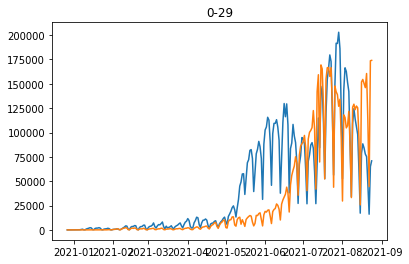

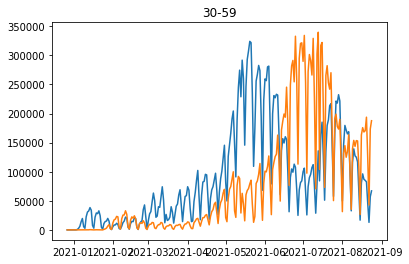

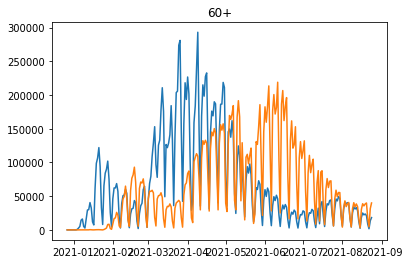

In [5]:
# Display vaccination rate in difft. age classes
for age_class in ['0-29', '30-59', '60+']:
    fig, ax = plt.subplots()
    d = df.loc[df.entity == 'France'].loc[df.age_class == age_class]
    s = ax.plot(d.jour, d.n_dose1)
    s = ax.plot(d.jour, d.n_complet)
    s = plt.title(age_class)

In [6]:
selected_columns = ['entity', 'age_class', 'jour',
       'taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'population', 'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']
df = df[selected_columns]
df.sample(5)

,entity,age_class,jour,taux hosp,taux rea,taux décès,taux dose 1,taux complet,population,incidence hebdo,taux de positifs hebdo,taux de tests hebdo
127293,90,30-59,2021-05-15,NaN,NaN,NaN,27.715285,11.551484,53162.0,156.126557,5.688828,2744.441518
160854,27,60+,2020-11-07,NaN,NaN,NaN,NaN,NaN,159303.0,368.480192,16.314619,2258.588978
67823,2A,whole,2021-07-28,NaN,NaN,NaN,63.427759,50.901669,162421.0,373.720147,3.495940,10690.120120
223596,94,0-29,2020-09-22,NaN,NaN,NaN,NaN,NaN,548476.0,174.848125,9.178790,1904.914709
152521,17,30-59,2020-10-07,NaN,NaN,NaN,NaN,NaN,230945.0,38.970318,3.802281,1024.919353


In [7]:
toc = time()
time_calculus = -tic+toc
print(f'{time_calculus:.2f} seconds to compute')

10.12 seconds to compute


# 3. Plot
## plots the indicators (uses matplotlib/pyplot)
* Type 1 figures = 7 indicators, same scale, France and all regions
* Type 0 figures = 1 indicator, 1 territory

In [8]:
tic = time()

In [9]:
regions = dc.regions
regions_metro = dc.regions_metro
regions_outre_mer = dc.regions_outre_mer
labels = ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo',
       'taux de positifs hebdo', 'taux de tests hebdo']
print(f"regions:\n{regions}\n\nregions_metro:\n{regions_metro}\n\nregions_outre_mer:\n{regions_outre_mer}\n\nlabels:\n{labels}\n")
for label in labels:
    maximum = df[df.entity.isin(dc.regions_metro)][label].max()
    print(f"{label}:\t{maximum:.2f}")
print('\n', df.age_class.unique())

regions:
['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur", 'Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']

regions_metro:
['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France', 'Île-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur"]

regions_outre_mer:
['Mayotte', 'Guyane', 'La Réunion', 'Guadeloupe', 'Martinique']

labels:
['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet', 'incidence hebdo', 'taux de positifs hebdo', 'taux de tests hebdo']

taux hosp:	371.79
taux rea:	57.97
taux décès:	53.83
taux dose 1:	97.12
taux complet:	93.54
incidence hebdo:	1207.86
taux de positifs hebdo:	25.28
taux de tests hebdo:	23036.62

 ['0-29' '30-59'

In [10]:
def order_entities(df, entities, label, age_class):
    """
    reorders entities (regions, départements...) by descending order of the last values of
    label / age_class
    df: dataframe
    regions: list of regions
    label: one of ['taux hosp', 'taux rea', 'taux décès', 'taux dose 1', 'taux complet',
       'incidence hebdo', 'taux de positifs hebdo', 'taux de tests hebdo']
    age_class: one of ['0-29', '30-59', '60+', 'whole']
    regions_ordered: regions ordered accordingly
    """
    jour = df[df[label].notna()].jour.max()
    entities_ordered = (df[(df.jour == jour) 
                            & (df.entity.isin(entities))
                         & (df.age_class == age_class)]
                        .groupby('entity')[label]
                        .mean()
                        .sort_values(ascending = False)
                        .index
                        .tolist()) 

    return entities_ordered

# Figures "type 1" normales

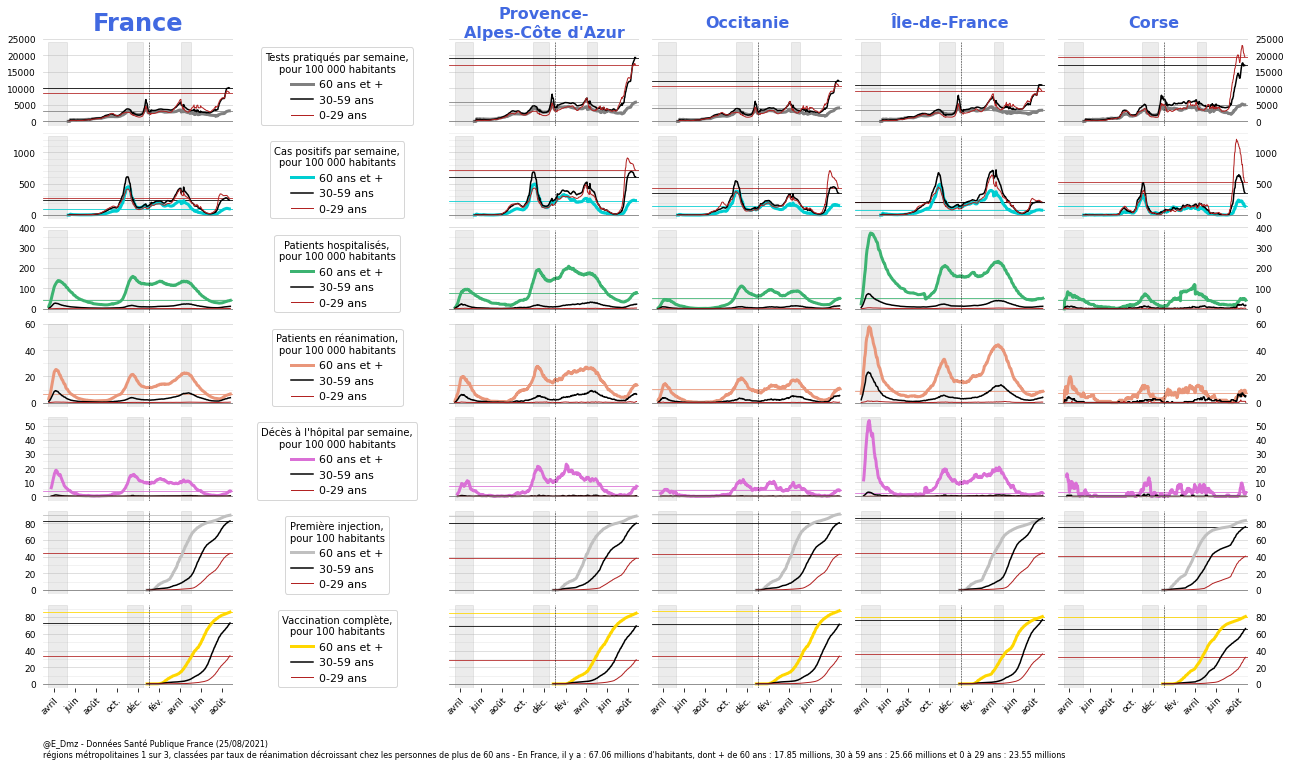

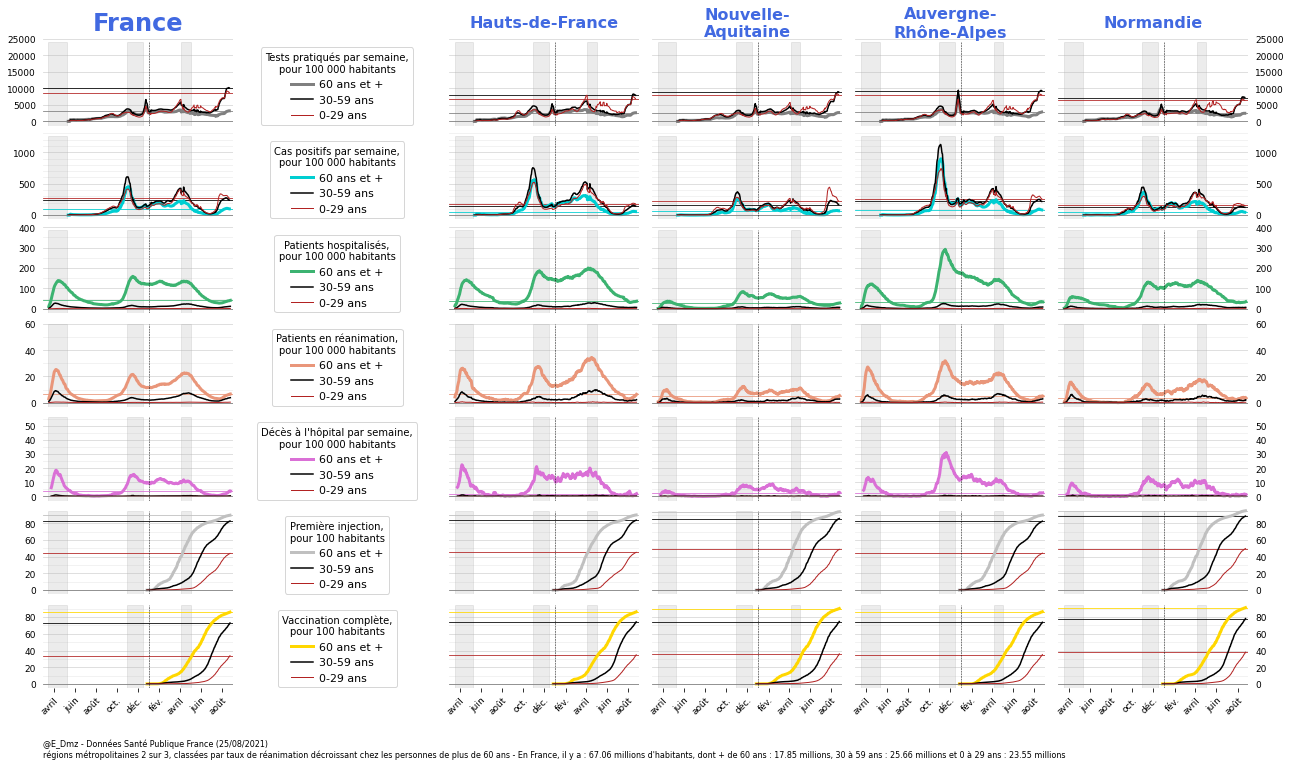

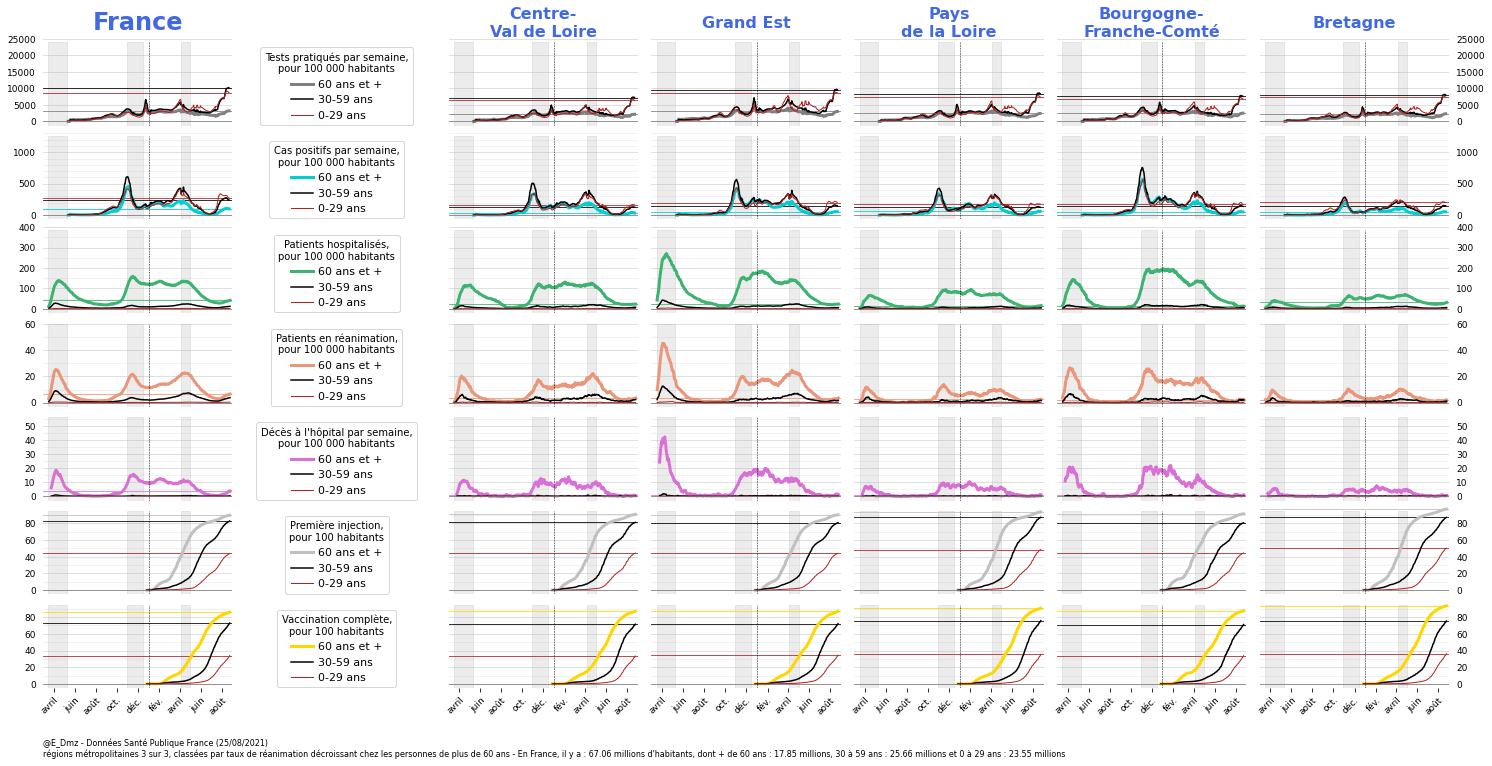

In [11]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)

# ajustement de l'échelle par le max sur la période:
graph_options = go.graph_options
for label in ['taux hosp', 'taux rea', 'taux décès', 
#                      'taux dose 1', 'taux complet', 
                     'incidence hebdo', 'taux de tests hebdo']:
    graph_options = go.scale_graph_by_age_class_max(graph_options, df, regions_metro, (label, ['0-29', '30-59', '60+']))

# regions metropolitaines, dans l'ordre décroissant du taux de réanimation des + de 60:
regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')

title_begins = 'régions métropolitaines'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de plus de 60 ans'


gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

# Fig Type 1 zoom

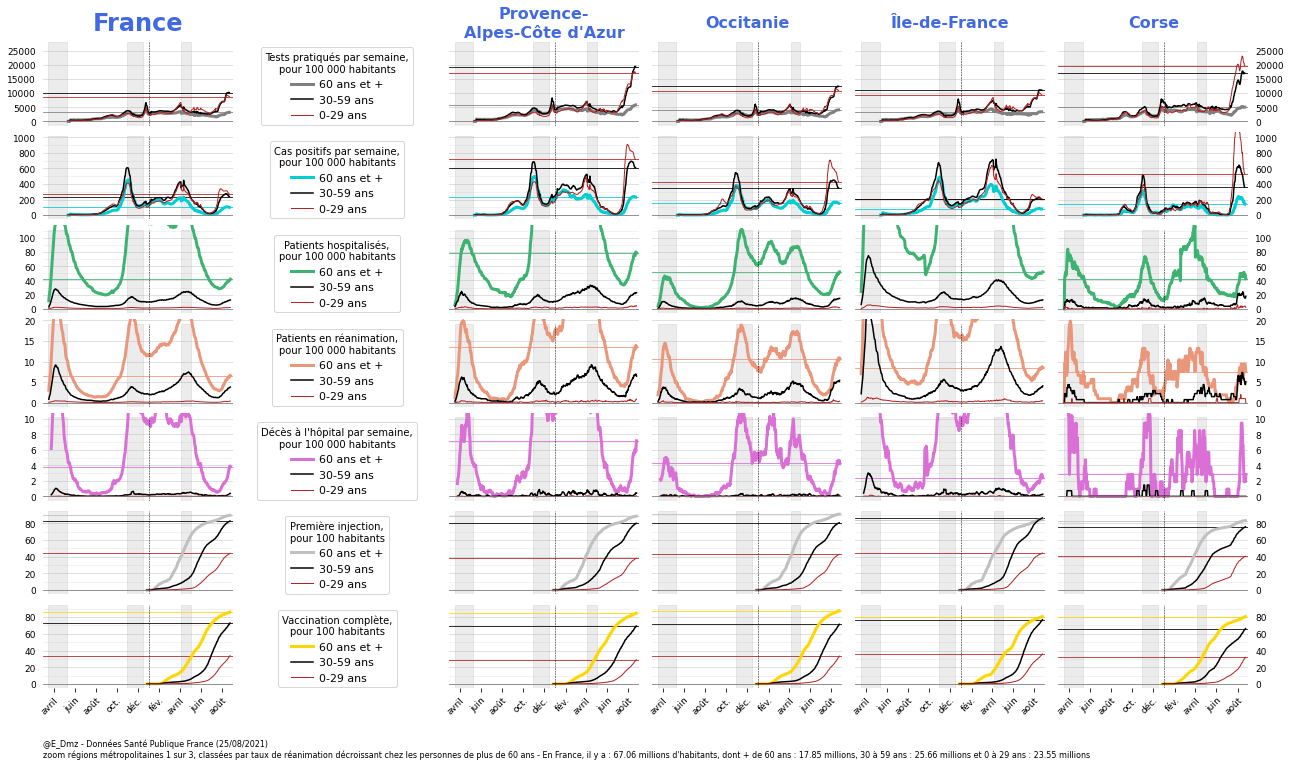

In [12]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)


graph_options = go.graph_options
for label in ['taux hosp', 'taux rea', 'taux décès', 
#                      'taux dose 1', 'taux complet', 
                     'incidence hebdo', 'taux de tests hebdo']:
    graph_options = go.scale_graph_by_age_class_last(graph_options, df, regions_metro, (label, ['0-29', '30-59', '60+']))

# regions metropolitaines, dans l'ordre décroissant du taux de réanimation des 60+:
regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')

title_begins = 'zoom régions métropolitaines'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de plus de 60 ans'


gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options = graph_options)
# gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

## Figures DROM

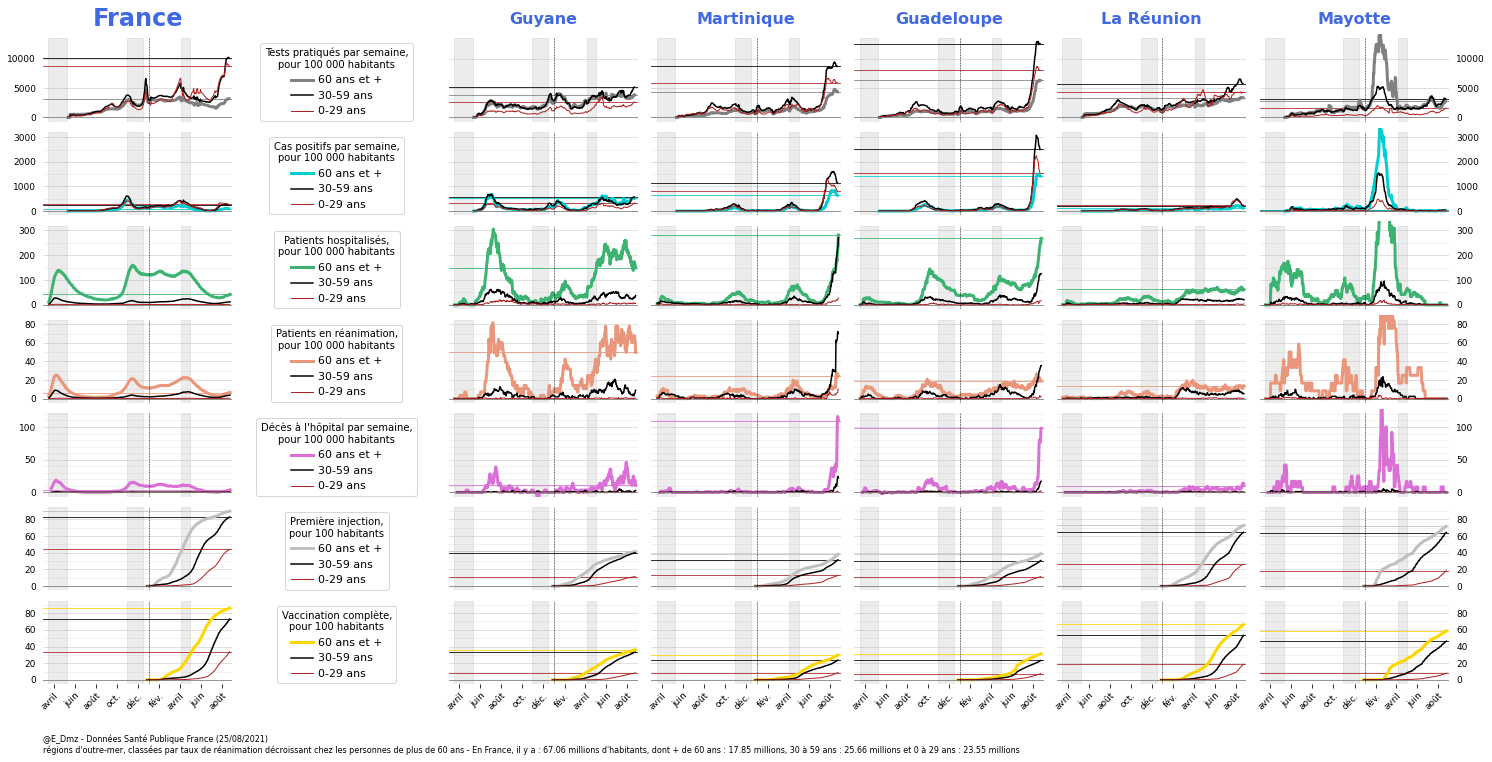

In [13]:
plt.rcParams["figure.facecolor"] = (1,1,1,1)

graph_options = go.graph_options
# Mayotte est exclue pour le calcul de l'échelle
for label in ['taux hosp', 'taux rea', 'taux décès', 
#                      'taux dose 1', 'taux complet', 
                     'incidence hebdo', 'taux de tests hebdo']:
    graph_options = go.scale_graph_by_age_class_max(graph_options, df, 
                                                    ['Guadeloupe', 'Martinique', 'Guyane', 'La Réunion'], 
                                                    (label, ['0-29', '30-59', '60+']))
    

# regions d'outre-mer, dans l'ordre décroissant du taux de réanimation des 60 ans:
regions_ordered = order_entities(df, regions_outre_mer, 'taux rea', '60+')

title_begins = 'régions d\'outre-mer'
title_ends = 'classées par taux de réanimation décroissant chez les personnes de plus de 60 ans'

# title_begins = 'zoom régions d\'outre-mer'
gf.fig_type1(df, regions_ordered, f'{title_begins}, {title_ends}', graph_options = graph_options)

### Figures zoom

In [14]:
# ### Figures zoom
# graph_options_alt_metro = go.scale_graph_by_age_class_last(df, regions_metro, 
#                          ('incidence hebdo', '30-59'),
#                          ('taux de tests hebdo', '30-59'),
#                          ('taux hosp', '60+'),
#                          ('taux rea', '60+'),
#                          ('taux décès', '60+'),
#                                                       factor = 1.1
#                         )

# plt.rcParams["figure.facecolor"] = (1,1,1,1)
# regions_ordered = order_entities(df, regions_metro, 'taux rea', '30-59')
# title_begins = 'zoom régions métropolitaines'
# title_ends = 'classées par taux de réanimation décroissant chez les personnes de 30 à 59 ans'
# graph_options = graph_options_alt_metro


# gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
# gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)



# # # regions_ordered = order_entities(df, regions_metro, 'taux rea', '60+')
# # regions_ordered = order_entities(df, regions_metro, 'incidence hebdo', '0-29')

# # title_begins = 'zoom régions métropolitaines'
# # title_ends = 'classées par incidence hebdomadaire décroissante chez les 0-29 ans'

# # graph_options = graph_options_alt_metro

# # gf.fig_type1(df, regions_ordered[:4], f'{title_begins} 1 sur 3, {title_ends}', graph_options)
# # gf.fig_type1(df, regions_ordered[4:8], f'{title_begins} 2 sur 3, {title_ends}', graph_options)
# # gf.fig_type1(df, regions_ordered[8:], f'{title_begins} 3 sur 3, {title_ends}', graph_options)

# Figures Type 0

## France et quelques régions

/home/edmz/DisplayDataCovid/Code/my_package/graph_functions.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize = (8, 4))


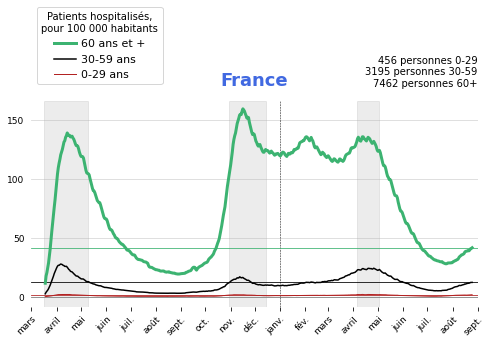

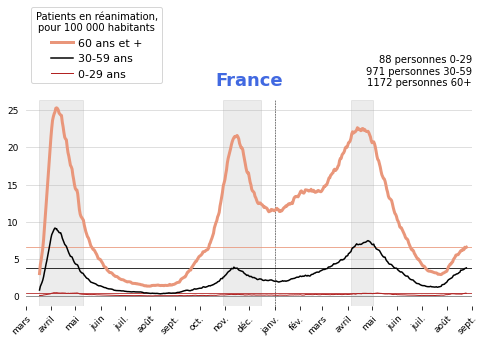

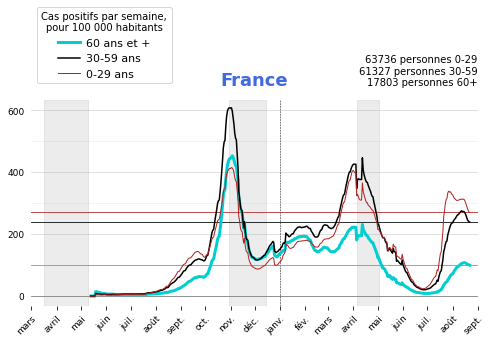

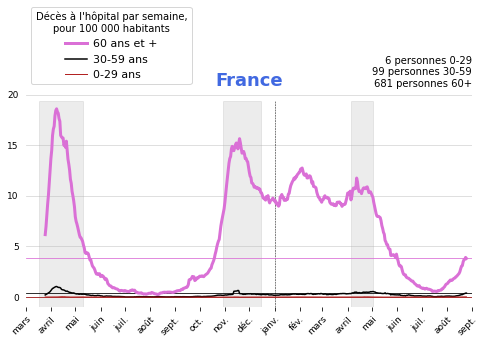

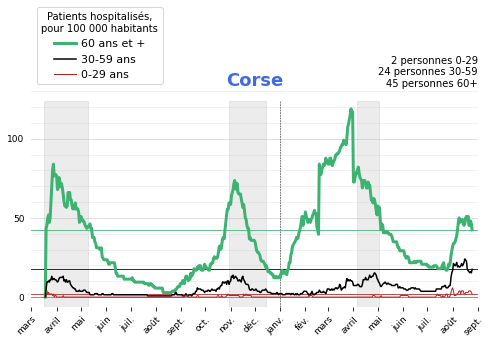

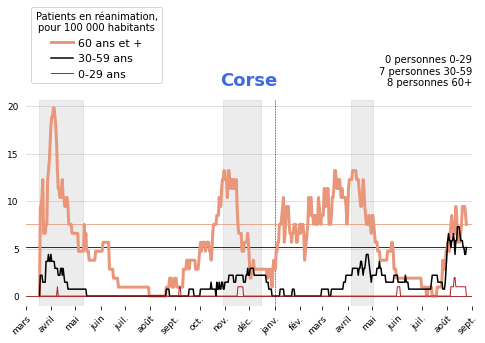

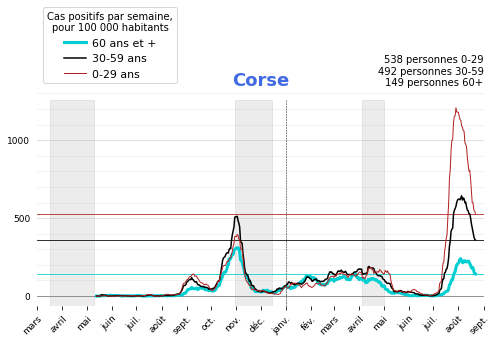

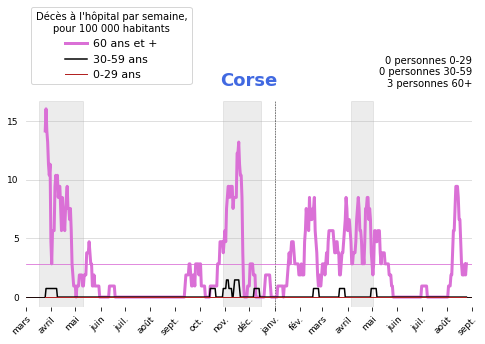

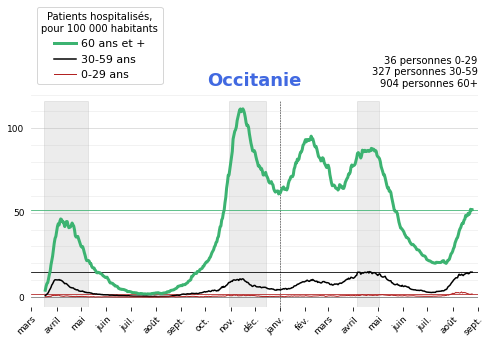

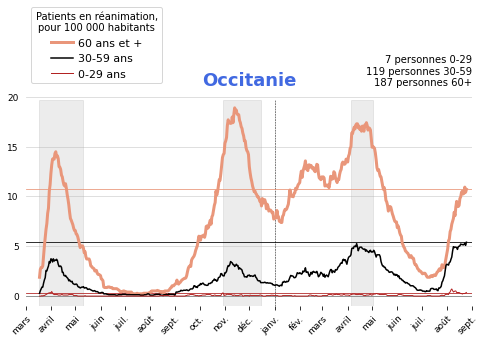

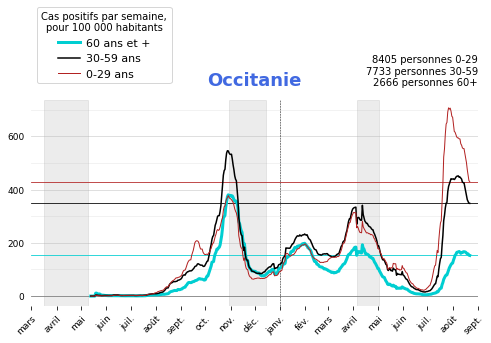

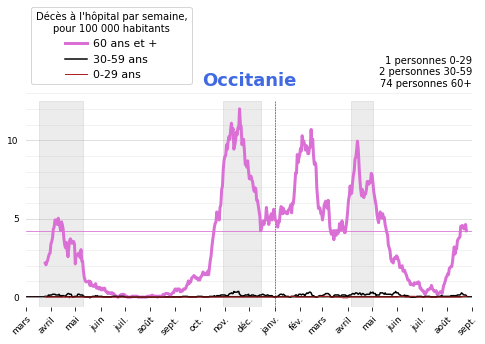

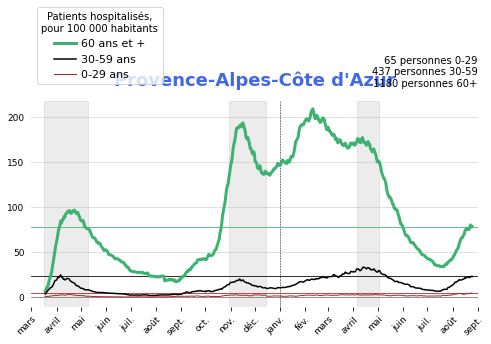

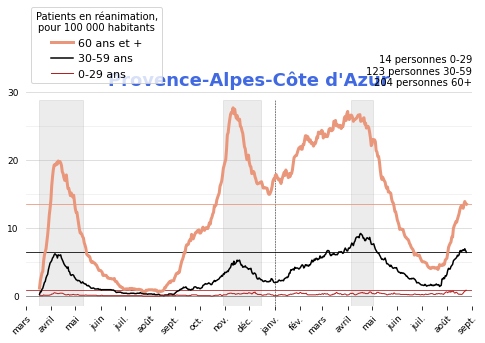

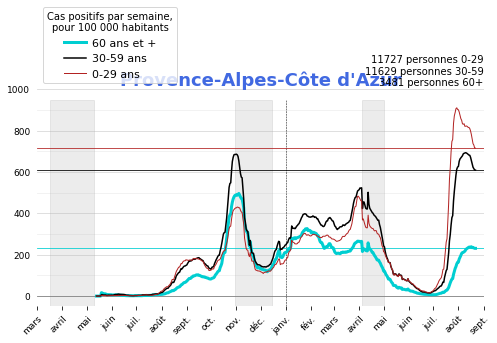

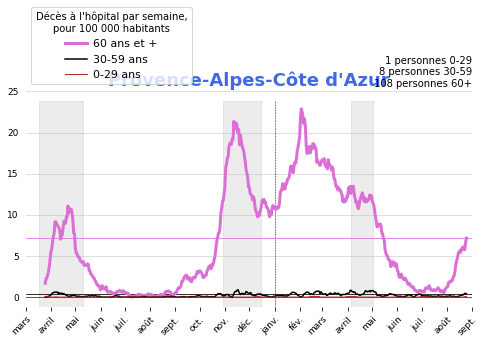

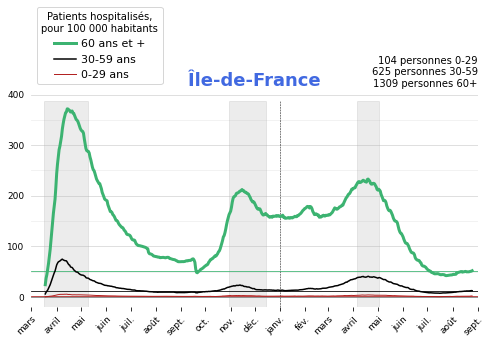

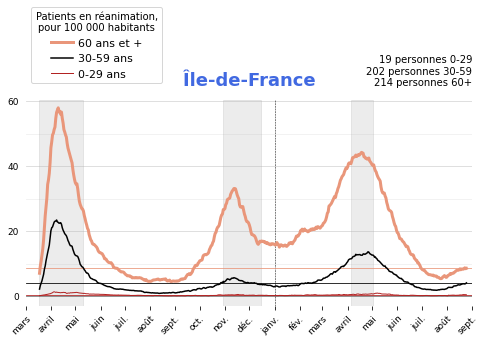

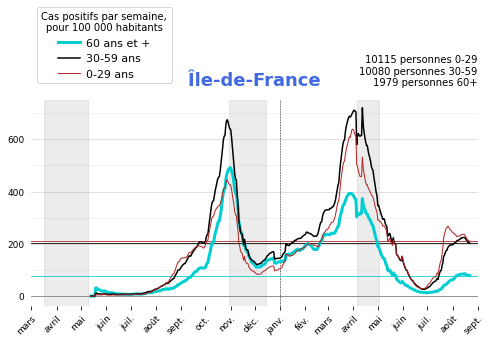

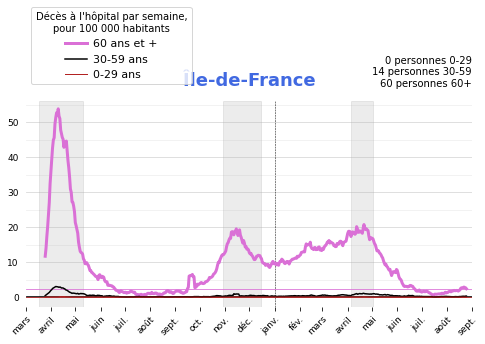

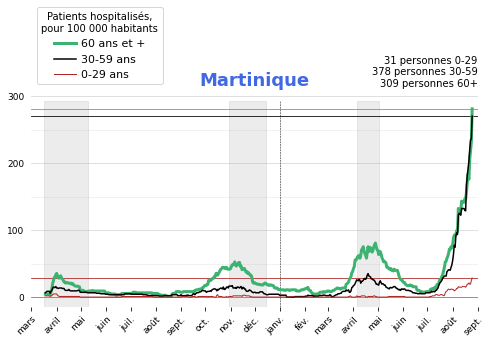

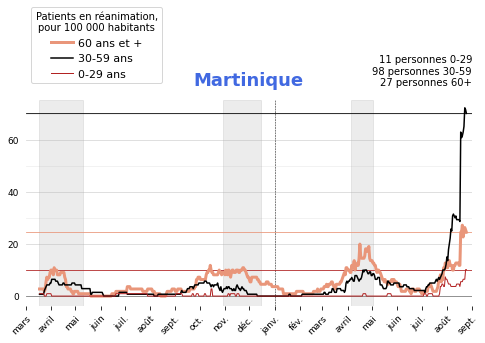

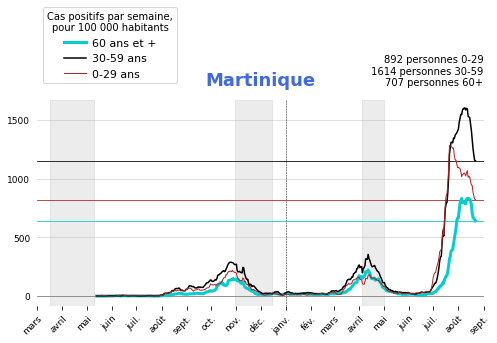

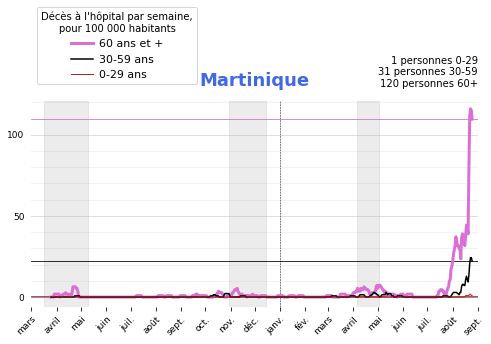

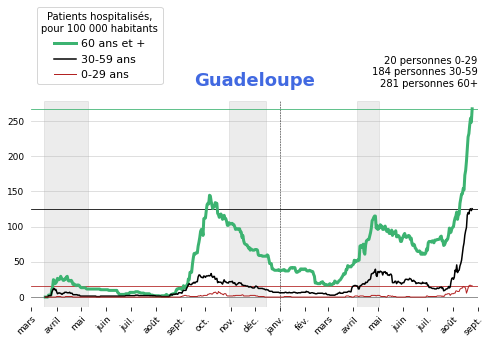

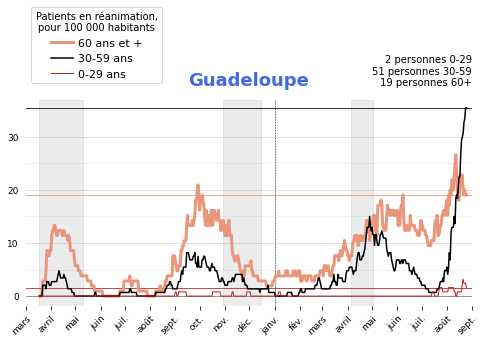

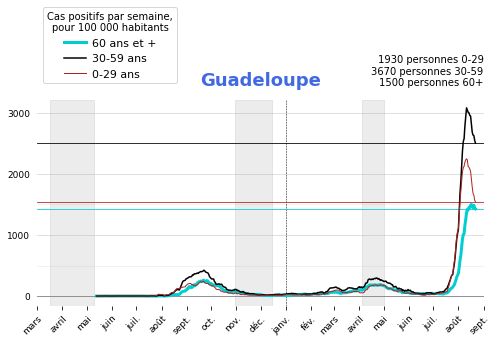

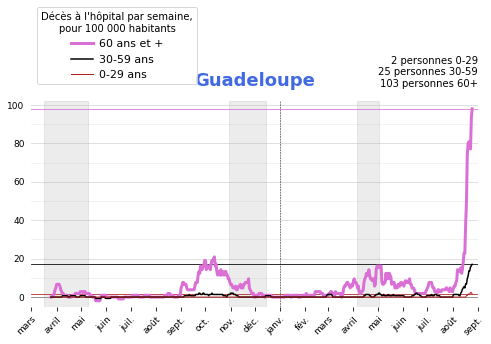

In [15]:
entities = ['France', 'Corse', 'Occitanie', "Provence-Alpes-Côte d'Azur", 'Île-de-France', 'Martinique', 'Guadeloupe',]
#entities = ['France', 'Occitanie', "Provence-Alpes-Côte d'Azur", 'Corse', 'Île-de-France', 'Martinique', 'Guyane']
# entities = ['France', 'Martinique', 'Guadeloupe', 'Occitanie', 'Île-de-France']
#entities =['France']
labels = ['taux hosp','taux rea', 'incidence hebdo', 'taux décès']

for entity in entities:
    graph_options = go.graph_options
    for label in labels:
        graph_options = go.scale_graph_by_age_class_max(graph_options, df, [entity], (label, ['0-29', '30-59', '60+']))
        plt.rcParams["figure.facecolor"] = (1,1,1,1)
        gf.simple_figure(df, entity, label, hline = ['0-29', '30-59', '60+'], graph_options = graph_options)


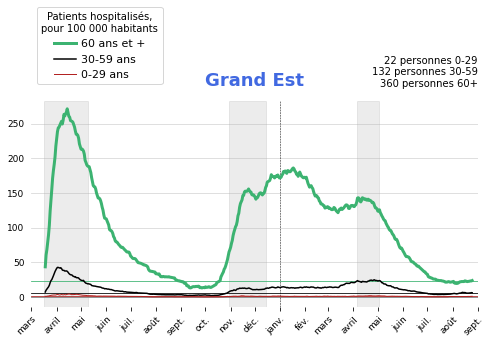

In [16]:
entities = ['Grand Est',]
#entities = ['France', 'Occitanie', "Provence-Alpes-Côte d'Azur", 'Corse', 'Île-de-France', 'Martinique', 'Guyane']
# entities = ['France', 'Martinique', 'Guadeloupe', 'Occitanie', 'Île-de-France']
#entities =['France']
labels = ['taux hosp']

for entity in entities:
    graph_options = go.graph_options
    for label in labels:
        graph_options = go.scale_graph_by_age_class_max(graph_options, df, [entity], (label, ['0-29', '30-59', '60+']))
        plt.rcParams["figure.facecolor"] = (1,1,1,1)
        gf.simple_figure(df, entity, label, hline = ['0-29', '30-59', '60+'], graph_options = graph_options)


In [17]:

# entities = ['Hauts-de-France',]
# labels = ['taux hosp','taux rea', 'incidence hebdo', 'taux décès']

# for entity in entities:

#     for label in labels:
#         plt.rcParams["figure.facecolor"] = (1,1,1,1)
#         gf.simple_figure(df, entity, label, hline = ['0-29', '30-59', '60+'], graph_options = go.graph_options, autoscale = True)


In [18]:
toc = time()
time_graph = -tic+toc
print(f'{time_graph:.2f} seconds to plot')

74.24 seconds to plot


# 4. Tweet
## generates tweets on a twitter account (Twitter API/python-twitter)
* publishes tweets from a text file
* @E_Dmz_Bot

In [22]:
tic = time()

import twitter
from my_package.tweets import tweets, media

print(len(tweets), len(media))

for tweet in tweets:
    print(len(tweet))

11 11
66
59
63
15
15
31
14
10
18
102
136


In [23]:
api = twitter.Api(**keys)
num_tweets = len(tweets)

for i in range(len(tweets)): # loop  accross the tweets
    
    tweet_begins = ''
    
    tweet_ends = f'\n\n{i+1}/{num_tweets}' if i ==0 else f'\n\n🤖 {i+1}/{num_tweets}'
    
    status = api.PostUpdate(
        f'{tweet_begins}{tweets[i]}{tweet_ends}',
        media = media[i],
        in_reply_to_status_id = None if i==0 else status.id,
        )
    status_0 = status if i == 0 else status_0

toc = time()
time_publish = -tic+toc
print(f'{time_publish:.2f} seconds to publish')

status = api.PostUpdate(f'🤖 Pour faire cette MAJ, il m\'a fallu : \n\
{time_download:.1f} s pour télécharger, \n\
{time_calculus:.1f} s pour calculer,\n\
{time_graph:.1f} s pour tracer\n\
et {time_publish:.1f} s pour publier',
                      in_reply_to_status_id = status.id)
status = api.PostRetweet(status_0.id)

29.97 seconds to publish


## Réponses requêtes Twitter

In [ ]:
# gf.simple_figure(df, 'Martinique', 'taux décès', autoscale = True)

# graph_options = go.scale_graph_by_age_class_last(df, ['Martinique'], ('incidence hebdo', '30-59'), ('taux rea', '30-59'), ('taux hosp', '60+'), factor = 1.1)

# gf.simple_figure(df, 'Martinique', 'taux rea', graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

# gf.simple_figure(df, 'Martinique', 'taux hosp', graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

# gf.simple_figure(df, 'Martinique', 'incidence hebdo', graph_options = graph_options, hline = ['0-29', '30-59', '60+'])

# gf.simple_figure(df, '66', 'incidence hebdo', autoscale = True)

# gf.simple_figure(df, 'Martinique', 'taux complet', autoscale = True)

# gf.simple_figure(df, 'Martinique', 'taux dose 1', autoscale = True)


# gf.simple_figure(df, 'Martinique', 'taux dose 1')

# gf.simple_figure(df, '75', 'incidence hebdo', autoscale = True)

# gf.simple_figure(df, 'Guyane', 'taux décès', graph_options = graph_options, autoscale = True)

# Autres graphes

In [ ]:

# gf.simple_figure(d, 'Grand Est', 'taux décès')
# gf.simple_figure(d, 'Corse', 'taux complet')
# gf.simple_figure(d, 'Nouvelle-Aquitaine', 'taux rea')
# gf.simple_figure(d, 'Hauts-de-France', 'taux de tests hebdo')

In [ ]:
# gf.simple_figure(d, 'France', 'taux hosp')
# gf.simple_figure(d, 'France', 'taux rea')
# gf.simple_figure(d, 'France', 'taux décès')

In [ ]:
# gf.simple_figure(d, 'Mayotte', 'incidence hebdo')
# gf.simple_figure(d, 'Mayotte', 'taux rea')
# gf.simple_figure(d, '976', 'incidence hebdo')

In [ ]:
def time_interval(jour = pd.Timestamp.now(), days = 1):
    period = pd.Timedelta(days, 'D')
    right = jour
    left = pd.Timestamp(jour - period)
    return pd.Interval(left, right)

time_interval()

In [ ]:
def last_value(df, entity, age_class, label):
    jour = df[df[label].notna()].jour.max()
    last_value = (df[(df.jour == jour) 
                    & (df.entity == entity)
                    & (df.age_class == age_class)])[label].values
    return last_value[0]

In [ ]:
def max_last_value(entities, age_class, label):
    last_values = []
    for entity in entities:
        last_values.append(last_value(entity, age_class, label))
    return max(last_values)  

In [ ]:
# jour = df[df['incidence hebdo'].notna()].jour.max()
# jour

# jour - pd.Timedelta(1,'D')

# df[(df.jour < jour)].jour.max()

# pd.Timestamp.now()

In [ ]:
# df[df.entity.isin(regions_metro)].max(axis = 0)

## Départements d'Île-de-France

In [ ]:
# entities = ['75', '93', '92', '94', '91', '95', '77', '78']
# graph_options = go.scale_graph_by_age_class(df, entities,
#                          ('incidence hebdo', '0-29'),
#                          ('taux de tests hebdo', '0-29'),
#                         )


# entities = order_entities(df, entities, 'incidence hebdo', '0-29')

# labels = ['incidence hebdo',]

# for entity in entities:
#     for label in labels:
#         gf.simple_figure(df, entity, label, graph_options = graph_options)